In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, InputLayer
from keras.optimizers import SGD
from keras.utils import plot_model
import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
import os
fileList = os.listdir("data/series/good")

In [4]:
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName not in [".DS",".ipynb"]:
        companyList.append(companyName)
print(companyList)

['VFC', 'KMB', 'NC', 'GWW', 'SJW', 'SEIC', 'EGN', 'NDSN', 'RLI', 'MATW', 'MCD', 'CLX', 'PG', 'UMBF', 'MMM', 'ROST', 'AFL', 'ABT', 'T', 'EXPD', 'CHD', 'BDX', 'GRC', 'FFMR', 'CTAS', 'PII', 'JNJ', 'CBU', 'BKH', 'LANC', 'NUE', 'WTRG', 'WABC', 'BANF', 'ECL', 'CPKF', 'SKT', 'MGEE', 'BEN', 'TGT', 'NEE', 'FLIC', 'CWT', 'TRI', 'CSL', 'NNN', 'ABM', 'CFR', 'SON', 'SRCE', 'CSVI', 'CINF', 'SPGI', 'AWR', 'O', 'IBM', 'WEYS', 'MSA', 'ESS', 'CBSH', 'NJR', 'LOW', 'CVX', 'EFSI', 'PBI', 'TR', 'ALB', 'EMR', 'AROW', 'TMP', 'MCY', 'LEG', 'ED', 'KO', 'NIDB', 'DOV', 'PH', 'ORI', 'FUL', 'TDS', 'WRE', 'MKC', 'FRT', 'PSBQ', 'GPC', 'MO', 'BMS', 'TNC', 'ENB', 'ITW', 'CTBI', 'BRO', 'AOS', 'PEP', 'ATR', 'UBSI', 'NFG', 'SHW', 'MDU', 'SCL', 'ROP', 'UGI', 'ARTNA', 'MGRC', 'WGL', 'MDT', 'CNI', 'LECO', 'TROW', 'RPM', 'ERIE', 'HRL', 'SWK', 'CB', 'ADM', 'APD', 'LIN', 'BMI', 'UHT', 'FMCB', 'ADP', 'CAT', 'SBSI', 'PNR', 'RTX', 'EBTC', 'NWN', 'OZK', 'JKHY', 'PPG', 'DBD', 'ATO', 'GD', 'WST', 'CL', 'WBA', 'TYCB', 'SYY', 'WMT', 'B

In [5]:
# First, we get the data
ignoreList = ["FFMR","FMCB"]
stockList = list(set(companyList).difference(ignoreList))
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])

In [6]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2006", "0")

/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


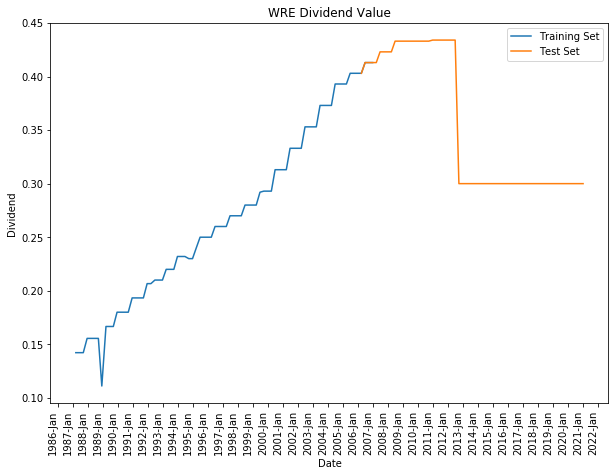

In [7]:
randidx = np.random.permutation(len(stockList))
shufStockList = np.array(stockList)[randidx]
for i in shufStockList:
    if df_new[i]["Train"].empty or df_new[i]["Test"].empty:
        print(i)
    if i in ["WRE"]:
        fig, axs = plt.subplots(1,1,figsize=(10, 7))
        axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#         axs.xaxis.set_minor_locator(mdates.MonthLocator())
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs.plot(df_new[i]["Train"].index, df_new[i]["Train"].values)
        axs.plot(df_new[i]["Test"].index,df_new[i]["Test"].values)
        axs.set_ylabel("Dividend")
        axs.set_xlabel("Date")
        for label in axs.get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')

        axs.legend(["Training Set", "Test Set"])
        axs.set_title(i + " Dividend Value")
        
        plt.savefig("WRE_Dataset.png", format="png")
        plt.show()


In [8]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(shufStockList):
    sc = MinMaxScaler(feature_range = (0,1)) # normalize values to be within [0,1]
    train = df_new[i]["Train"].values
    test = df_new[i]["Test"].values
    
    train = np.expand_dims(train, axis = 1)
    test = np.expand_dims(test, axis = 1)
    transform_train[i] = sc.fit_transform(train)
    transform_test[i] = sc.fit_transform(test)
    scaler[i] = sc

del train
del test

In [9]:
transform_train[i].shape

(53, 1)

In [10]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

GD (144, 1)
XOM (182, 1)
ITW (81, 1)
PG (181, 1)
SRCE (80, 1)
WRE (80, 1)
WEYS (84, 1)
NJR (84, 1)
DOV (100, 1)
RPM (80, 1)
SCL (80, 1)
MGEE (81, 1)
PBI (141, 1)
TYCB (20, 1)
THFF (60, 1)
FRT (81, 1)
TGT (96, 1)
PPG (96, 1)
ABM (92, 1)
PH (88, 1)
CSL (80, 1)
RTX (180, 1)
WBA (88, 1)
GPC (96, 1)
ORI (82, 1)
T (92, 1)
ERIE (44, 1)
CINF (84, 1)
NDSN (84, 1)
LANC (84, 1)
CFR (52, 1)
BANF (64, 1)
UGI (88, 1)
CL (136, 1)
EMR (141, 1)
CB (56, 1)
KO (180, 1)
SJW (109, 1)
AFL (92, 1)
SON (68, 1)
TR (85, 1)
MCD (128, 1)
TROW (84, 1)
ENB (68, 1)
AROW (80, 1)
PEP (141, 1)
ADP (96, 1)
BRC (60, 1)
ATO (72, 1)
SKT (56, 1)
CTAS (80, 1)
IBM (180, 1)
NC (89, 1)
VFC (84, 1)
BEN (88, 1)
NWN (69, 1)
APD (96, 1)
UMBF (84, 1)
CVX (152, 1)
MATW (52, 1)
TRI (20, 1)
BMS (84, 1)
WST (80, 1)
BMI (68, 1)
SEIC (72, 1)
NFG (80, 1)
EGN (88, 1)
CLX (100, 1)
JNJ (180, 1)
SYY (82, 1)
SYK (64, 1)
EBTC (8, 1)
PII (75, 1)
HP (81, 1)
ROST (52, 1)
HRL (81, 1)
ADM (96, 1)
BKH (80, 1)
TNC (80, 1)
MDU (84, 1)
UBSI (80, 1)
MMM (

In [11]:
# dynamically determine which samples have enough information to be trained 

train_lengths = [data.shape[0] for data in transform_train.values()] 
val, ct = np.unique(np.array(train_lengths), return_counts=True)
train_count = val[np.argsort(ct)][-1]

test_lengths = [data.shape[0] for data in transform_test.values()] 
val, ct = np.unique(np.array(test_lengths), return_counts=True)
test_count = val[np.argsort(ct)][-1]

In [12]:
train_count, test_count

(80, 60)

In [13]:
overlap = 5

trainset = {}
testset = {}
stockListFix = []
testDates = {}
for j in stockList:
        if transform_train[j].shape[0] < train_count or transform_test[j].shape[0] < test_count:
            continue
        stockListFix.append(j)
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(overlap,train_count):
            X_train.append(transform_train[j][i-overlap:i,0])
            y_train.append(transform_train[j][i,0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.expand_dims(X_train, axis=len(X_train.shape))
        trainset[j]["y"] = y_train

        testset[j] = {}
        X_test = []
        y_test = []   
        testDates[j] = []
        for i in range(overlap, test_count):
            X_test.append(transform_test[j][i-overlap:i,0])
            y_test.append(transform_test[j][i,0])
            testDates[j].append(df_new[j]['Test'].index[i])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.expand_dims(X_test, axis=len(X_test.shape))
        testset[j]["y"] = y_test

In [14]:
arr_buff = []
for i in stockListFix:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockListFix)

,X_train,y_train,X_test,y_test
WST,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
ITW,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
UGI,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
SYY,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
UHT,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
...,...,...,...,...
MO,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
MMM,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
TR,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
BRO,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"


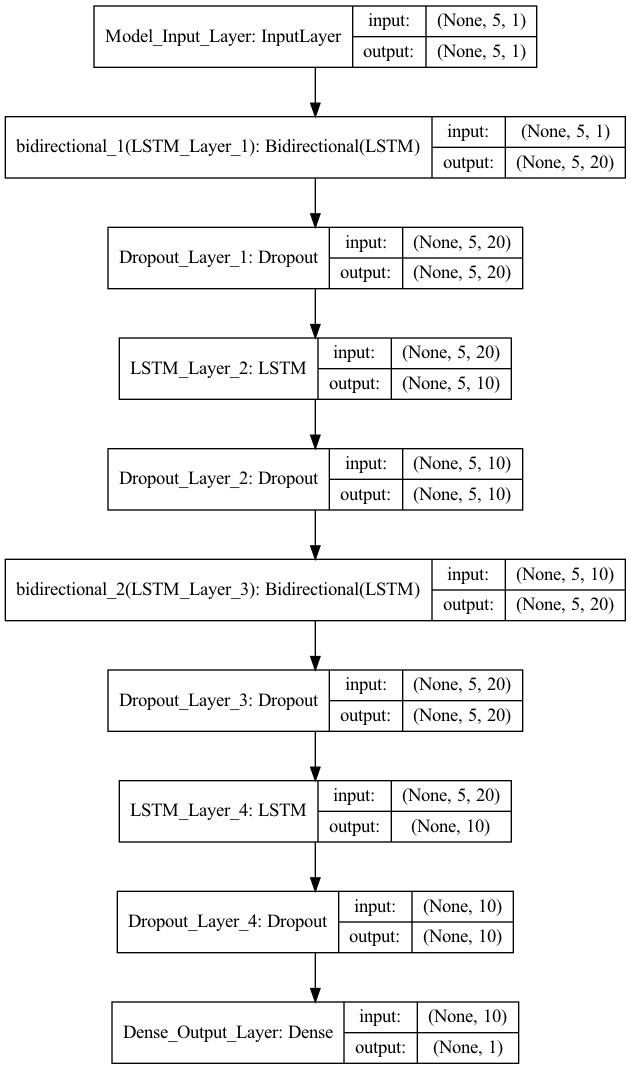

In [15]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularization
regressor.add(InputLayer(input_shape=(X_train.shape[1],1), name = "Model_Input_Layer"))
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True, name="LSTM_Layer_1")))
regressor.add(Dropout(0.2,name="Dropout_Layer_1"))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True,name="LSTM_Layer_2"))
regressor.add(Dropout(0.2,name="Dropout_Layer_2"))
# Third LSTM layer
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True,name="LSTM_Layer_3")))
regressor.add(Dropout(0.5,name="Dropout_Layer_3"))
# Fourth LSTM layer
regressor.add(LSTM(units=10, name="LSTM_Layer_4"))
regressor.add(Dropout(0.5,name="Dropout_Layer_4"))
# The output layer
regressor.add(Dense(units=1, name="Dense_Output_Layer")) 

plot_model(
    regressor,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

In [16]:
%%time
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
for i in stockListFix:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=5,verbose=0)

Fitting to WST

Fitting to ITW
Fitting to UGI
Fitting to SYY
Fitting to UHT
Fitting to XOM
Fitting to TGT
Fitting to KMB
Fitting to JNJ
Fitting to DCI
Fitting to PBI
Fitting to NFG
Fitting to MCD
Fitting to MDT
Fitting to PPG
Fitting to SRCE
Fitting to CAT
Fitting to KO
Fitting to NC
Fitting to NDSN
Fitting to TDS
Fitting to RPM
Fitting to VFC
Fitting to CBSH
Fitting to PEP
Fitting to GPC
Fitting to HRL
Fitting to LEG
Fitting to WMT
Fitting to MGEE
Fitting to CL
Fitting to FRT
Fitting to TROW
Fitting to WABC
Fitting to ADM
Fitting to NJR
Fitting to WBA
Fitting to CVX
Fitting to APD
Fitting to NUE
Fitting to AFL
Fitting to RLI
Fitting to SJW
Fitting to MDU
Fitting to NEE
Fitting to WTRG
Fitting to UBSI
Fitting to O
Fitting to AROW
Fitting to PH
Fitting to SHW
Fitting to HP
Fitting to UVV
Fitting to MSEX
Fitting to ED
Fitting to AOS
Fitting to IBM
Fitting to SCL
Fitting to LOW
Fitting to ORI
Fitting to CWT
Fitting to TNC
Fitting to EMR
Fitting to FUL
Fitting to SWK
Fitting to LANC
Fittin

/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


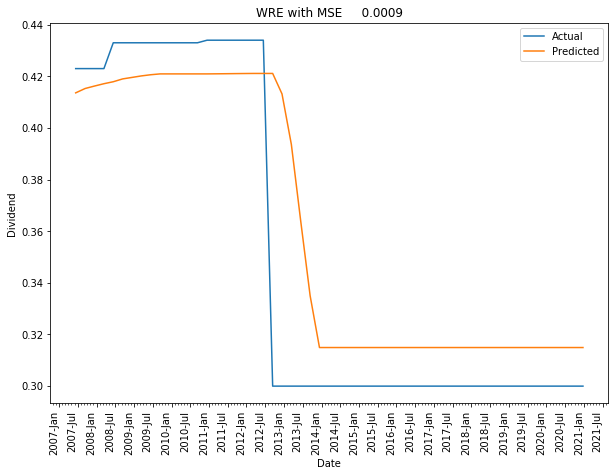

In [17]:
pred_result = {}
for i in stockListFix:
    if i in shufStockList:
            y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
            y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
            MSE = mean_squared_error(y_true, y_pred)
            pred_result[i] = {}
            pred_result[i]["True"] = y_true
            pred_result[i]["Pred"] = y_pred
            if i in ["WRE"]:
                fig, axs = plt.subplots(1,1,figsize=(10, 7))
                axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
                axs.xaxis.set_minor_locator(mdates.MonthLocator())
                axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  
                axs.plot(pd.DatetimeIndex(testDates[i]), y_true)
                axs.plot(pd.DatetimeIndex(testDates[i]),y_pred)
                axs.set_ylabel("Dividend")
                axs.set_xlabel("Date")
                for label in axs.get_xticklabels(which='major'):
                    label.set(rotation=90, horizontalalignment='right')

                axs.legend(["Actual", "Predicted"])
                axs.set_title("{} with MSE {:10.4f}".format(i,MSE))
                plt.savefig("WRE_Prediction.png", format="png")
                plt.show()

In [18]:
time_index = df_new["WRE"]["Test"][overlap:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag])))

    fig, axs = plt.subplots(1,1,figsize=(10, 7))
    axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axs.xaxis.set_minor_locator(mdates.MonthLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  
    axs.plot(df_true)
    axs.plot(df_pred)
    axs.set_ylabel("Dividend")
    axs.set_xlabel("Date")
    for label in axs.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')

    axs.legend(["Actual", "Predicted"])
    axs.set_title("Prediction")
    plt.show()

    MSE_lag = mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag]))
    fig, axs = plt.subplots(1,1,figsize=(10, 7))
    axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axs.xaxis.set_minor_locator(mdates.MonthLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  
    axs.plot(df_true)
    axs.plot(df_pred_lag)
    axs.set_ylabel("Dividend")
    axs.set_xlabel("Date")
    for label in axs.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')

    axs.legend(["Actual", "Predicted"])
    axs.set_title("{} (Lag Adjusted) with MSE {:10.4f}".format("WRE",MSE_lag))
    plt.savefig("WRE_Prediction_Lag.png", format="png")

    plt.show()
    

MSE without Lag 0.0008043721591530943
MSE with Lag 5 0.0005353365612087142


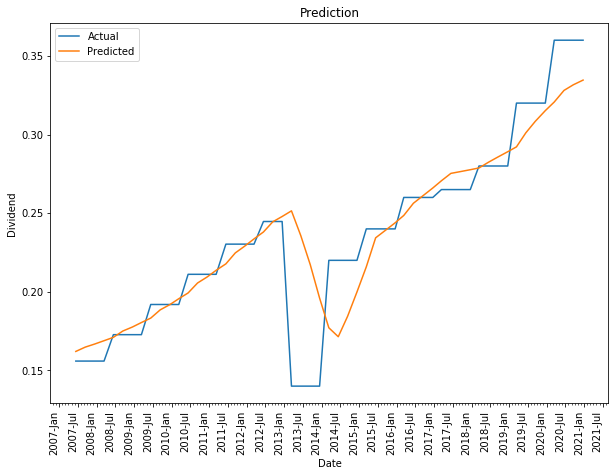

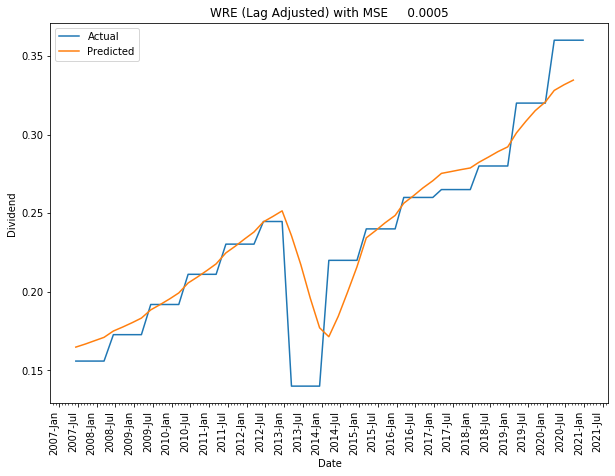

In [20]:
lagging(pred_result["ABT"], -1, time_index)